In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

from pylib.draw_nn import draw_neural_net_fig

In [3]:
sess = None

def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [4]:
mnist = input_data.read_data_sets('/tmp/data', one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
N_PIXELS= 28 * 28
N_CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.5

In [6]:
n_steps = 50000

In [7]:
hidden_size = 256

In [8]:
reset_tf()

x = tf.placeholder(tf.float32, [None, N_PIXELS], name="pixels")
y_label = tf.placeholder(tf.float32, [None, 10], name="labels")
training = tf.placeholder(tf.bool, name="training")

hidden1 = tf.layers.dense(x, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=N_PIXELS**-0.5))

hidden2 = tf.layers.dense(hidden1, hidden_size, activation=tf.nn.sigmoid, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

y = tf.layers.dense(hidden2, 10, activation=None, use_bias=True,
    kernel_initializer=tf.truncated_normal_initializer(stddev=hidden_size**-0.5))

In [9]:
def train_mnist(x, y_label, loss, accuracy, train, training, steps_total, steps_print):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    reset_vars()
    for i in xrange(steps_total):
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        sess.run(train,
                 feed_dict={x: batch_x, y_label: batch_y, training: True})
        if i % steps_print == 0 or i == steps_total - 1:
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.test.images,
                                       y_label: mnist.test.labels,
                                       training: False})
            metrics['test_loss'].append(l)
            metrics['test_acc'].append(a)
            print "Test:  %0.5f, %0.5f" % (l, a)
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.train.images, 
                                       y_label: mnist.train.labels,
                                       training: False})
            metrics['train_loss'].append(l)
            metrics['train_acc'].append(a)
            print "Train: %0.5f, %0.5f" % (l, a)
    return metrics

In [10]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y,
                                                              labels=y_label))
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_label, 1)), tf.float32))

res = train_mnist(x, y_label, loss, accuracy, train, training, n_steps, 1000);

Test:  3.04423, 0.10320
Train: 3.05122, 0.09945
Test:  0.29133, 0.91340
Train: 0.30452, 0.91089
Test:  0.22209, 0.93320
Train: 0.22176, 0.93429
Test:  0.16256, 0.95160
Train: 0.15965, 0.95313
Test:  0.13835, 0.95650
Train: 0.12944, 0.96251
Test:  0.12615, 0.96030
Train: 0.11148, 0.96631
Test:  0.11430, 0.96590
Train: 0.09291, 0.97302
Test:  0.09154, 0.97100
Train: 0.07131, 0.97887
Test:  0.08693, 0.97230
Train: 0.05953, 0.98307
Test:  0.09229, 0.97170
Train: 0.05998, 0.98216
Test:  0.07855, 0.97560
Train: 0.04422, 0.98735
Test:  0.07659, 0.97630
Train: 0.03739, 0.98980
Test:  0.08134, 0.97440
Train: 0.04259, 0.98633
Test:  0.07682, 0.97760
Train: 0.03320, 0.98978
Test:  0.07209, 0.97870
Train: 0.02376, 0.99411
Test:  0.07191, 0.97860
Train: 0.02111, 0.99480
Test:  0.07214, 0.97770
Train: 0.01657, 0.99689
Test:  0.07193, 0.97920
Train: 0.01365, 0.99796
Test:  0.07480, 0.97830
Train: 0.01312, 0.99762
Test:  0.07110, 0.97880
Train: 0.00963, 0.99896
Test:  0.07415, 0.97760
Train: 0.00963, 

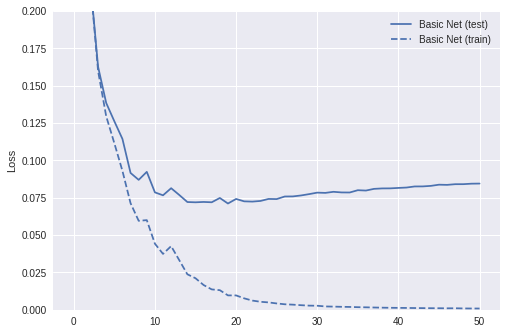

In [11]:
snc = sns.color_palette()

plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)'])
plt.ylabel('Loss');

In [12]:
sess.run([loss, accuracy], {x: mnist.test.images,
                            y_label: mnist.test.labels,
                            training: False})

[0.084441349, 0.97979999]

In [13]:
def train_mnist_early_stopping(x, y_label, loss, accuracy, train, training, steps_total, steps_print):
    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    saver = tf.train.Saver()
    best_loss = 100
    steps_since_best = 0
    reset_vars()
    for i in xrange(steps_total):
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        sess.run(train,
                 feed_dict={x: batch_x, y_label: batch_y, training: True})
        if i % steps_print == 0 or i == steps_total - 1:
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.test.images,
                                       y_label: mnist.test.labels,
                                       training: False})
            metrics['test_loss'].append(l)
            metrics['test_acc'].append(a)
            print "%i Test:  %0.5f, %0.5f" % (i, l, a)
            if l < best_loss:
                best_loss = l
                saver.save(sess, "/tmp/mnist_model.ckpt")
                steps_since_best = 0
            else:
                steps_since_best += 1
                if steps_since_best >= 5:
                    break
            
            l, a = sess.run([loss, accuracy],
                            feed_dict={x: mnist.train.images, 
                                       y_label: mnist.train.labels,
                                       training: False})
            metrics['train_loss'].append(l)
            metrics['train_acc'].append(a)
            print "%i Train: %0.5f, %0.5f" % (i, l, a)
    
    saver.restore(sess, "/tmp/mnist_model.ckpt")
    
    return metrics

In [14]:
res_es = train_mnist_early_stopping(x, y_label, loss, accuracy, train, training, n_steps, 1000);

0 Test:  2.92722, 0.09800
0 Train: 2.93175, 0.09898
1000 Test:  0.31552, 0.90750
1000 Train: 0.32602, 0.90353
2000 Test:  0.22089, 0.93480
2000 Train: 0.22290, 0.93451
3000 Test:  0.17747, 0.94700
3000 Train: 0.17364, 0.94802
4000 Test:  0.13935, 0.95650
4000 Train: 0.13002, 0.96173
5000 Test:  0.12297, 0.96410
5000 Train: 0.10838, 0.96849
6000 Test:  0.10275, 0.96820
6000 Train: 0.08374, 0.97562
7000 Test:  0.10837, 0.96740
7000 Train: 0.08088, 0.97591
8000 Test:  0.11115, 0.96550
8000 Train: 0.07819, 0.97633
9000 Test:  0.08342, 0.97290
9000 Train: 0.05254, 0.98485
10000 Test:  0.08040, 0.97420
10000 Train: 0.04455, 0.98676
11000 Test:  0.07340, 0.97670
11000 Train: 0.03540, 0.99031
12000 Test:  0.07741, 0.97600
12000 Train: 0.03285, 0.99069
13000 Test:  0.07217, 0.97690
13000 Train: 0.02574, 0.99335
14000 Test:  0.07016, 0.97970
14000 Train: 0.02259, 0.99484
15000 Test:  0.06723, 0.98030
15000 Train: 0.01766, 0.99644
16000 Test:  0.06825, 0.98040
16000 Train: 0.01591, 0.99696
17000 

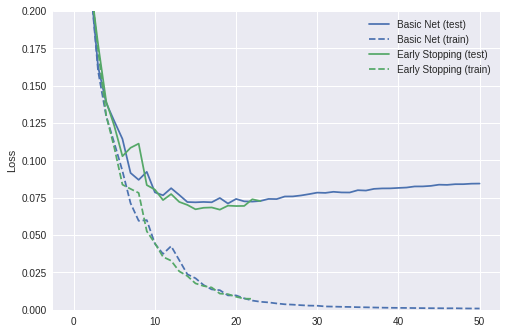

In [15]:
plt.plot(res['test_loss'], color=snc[0])
plt.plot(res['train_loss'], color=snc[0], ls='--')
plt.plot(res_es['test_loss'], color=snc[1])
plt.plot(res_es['train_loss'], color=snc[1], ls='--')
plt.ylim(0., 0.2)
plt.legend(['Basic Net (test)', 'Basic Net (train)',
            'Early Stopping (test)', 'Early Stopping (train)'])
plt.ylabel('Loss');

In [16]:
sess.run([loss, accuracy], {x: mnist.test.images,
                            y_label: mnist.test.labels,
                            training: False})

[0.066991426, 0.98089999]

*Copyright &copy; 2017 The Data Incubator.  All rights reserved.*